### Import



In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import missingno as mno
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.io as pio
from wordcloud import WordCloud
from ast import main

color_pal = sns.color_palette()
plt.style.use('seaborn-dark-palette')
plt.style.use('dark_background')

import nltk

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
sns.set_theme(style='darkgrid', palette='colorblind')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Lettura dataset e ETL

In [43]:
# Lettura dati riguardanti l'oro
# Consideriamo soltanto i dati compresi tra 21-08-2017 e il 21-08-2020
# N.B. 18 settimane per il campo stock-price sono il minimo per parlare di trend
gold = pd.read_csv('/content/drive/MyDrive/gold/gold-price-last-ten-years.csv', sep=',', header=8)
gold['date']=pd.to_datetime(gold['date'])
focus = (gold['date'] > '2017-08-21') & (gold['date'] <= '2020-08-21')
maindf = gold.loc[focus]
maindf.columns = ['Date', 'GLD']

In [44]:
# Lettura dati riguardanti S&P500
SP500=pd.read_csv('/content/drive/MyDrive/gold/SP500 2007-2020.csv', sep=',', header=7)
SP500['date'] = pd.to_datetime(SP500['date'])
SP500.columns = ['Date', 'SPX']
maindf=maindf.merge(SP500, how='left', on='Date')

In [45]:
# Lettura dati riguardanti Barrick
barrick = pd.read_csv('/content/drive/MyDrive/gold/Barrick Gold Corp 1985-2020.csv', sep=',', header=9)
barrick['date'] = pd.to_datetime(barrick['date'])
barrick = barrick[['date', 'close']]
barrick.columns = ['Date','BARR']
maindf = maindf.merge(barrick, how='left', on='Date')

In [46]:
# Lettura dati riguardant l'argento
silver = pd.read_csv('/content/drive/MyDrive/gold/silver history.csv', sep=',', header=7)
silver['date']=pd.to_datetime(silver['date'])
silver.columns = ['Date', 'SLV']
maindf = maindf.merge(silver, how='left', on='Date')

In [47]:
maindf.head()

,Date,GLD,SPX,BARR,SLV
0,2017-08-22,1291.0,2452.51,16.5072,17.060
1,2017-08-23,1294.7,2444.04,16.6639,17.126
2,2017-08-24,1292.0,2438.97,16.6932,17.046
3,2017-08-25,1297.9,2443.05,16.7814,17.132
4,2017-08-28,1315.3,2444.24,17.3003,17.529


In [48]:
# Check prima di assegnare "Date" come indice
maindf['Date'].value_counts().head()

Date
2017-08-22    1
2019-08-28    1
2019-08-14    1
2019-08-15    1
2019-08-16    1
Name: count, dtype: int64

In [49]:
# Setto "Date" come indice
maindf= maindf.set_index('Date')
maindf.head()

,GLD,SPX,BARR,SLV
Date,,,,
2017-08-22,1291.0,2452.51,16.5072,17.060
2017-08-23,1294.7,2444.04,16.6639,17.126
2017-08-24,1292.0,2438.97,16.6932,17.046
2017-08-25,1297.9,2443.05,16.7814,17.132
2017-08-28,1315.3,2444.24,17.3003,17.529


In [50]:
# Verifica della presenza di valori null nel dataframe
maindf.isnull().sum()

GLD      0
SPX     16
BARR    16
SLV     11
dtype: int64

In [51]:
# Li rimpiazzo tranquillamente, tendendo d'occhio la media e la deviazione standard prima di usare ffill
maindf.describe()

,GLD,SPX,BARR,SLV
count,759.000000,743.000000,743.000000,748.000000
mean,1405.848419,2846.261023,16.046517,16.575697
std,186.315921,226.333878,4.703624,2.132119
min,1176.700000,2237.400000,9.666000,11.772000
25%,1281.300000,2688.700000,12.871200,15.242500
50%,1324.950000,2821.930000,14.123100,16.463300
75%,1503.750000,2978.735000,17.760450,17.279250
max,2061.500000,3397.160000,30.130000,29.261000


In [52]:
maindf = maindf.fillna(axis=0, method='ffill')
maindf.describe()

,GLD,SPX,BARR,SLV
count,759.000000,759.000000,759.000000,759.000000
mean,1405.848419,2846.759908,16.037577,16.573859
std,186.315921,227.016344,4.687174,2.123482
min,1176.700000,2237.400000,9.666000,11.772000
25%,1281.300000,2688.700000,12.882800,15.244900
50%,1324.950000,2820.400000,14.123100,16.460600
75%,1503.750000,2979.075000,17.760900,17.282500
max,2061.500000,3397.160000,30.130000,29.261000


In [53]:
maindf.isnull().sum()

GLD     0
SPX     0
BARR    0
SLV     0
dtype: int64

Rimpiazzando i valori null con ffill, non cambiano le caratteristiche del dataset, come media e deviazione standard.

### EDA

Text(0, 0.5, 'Value')

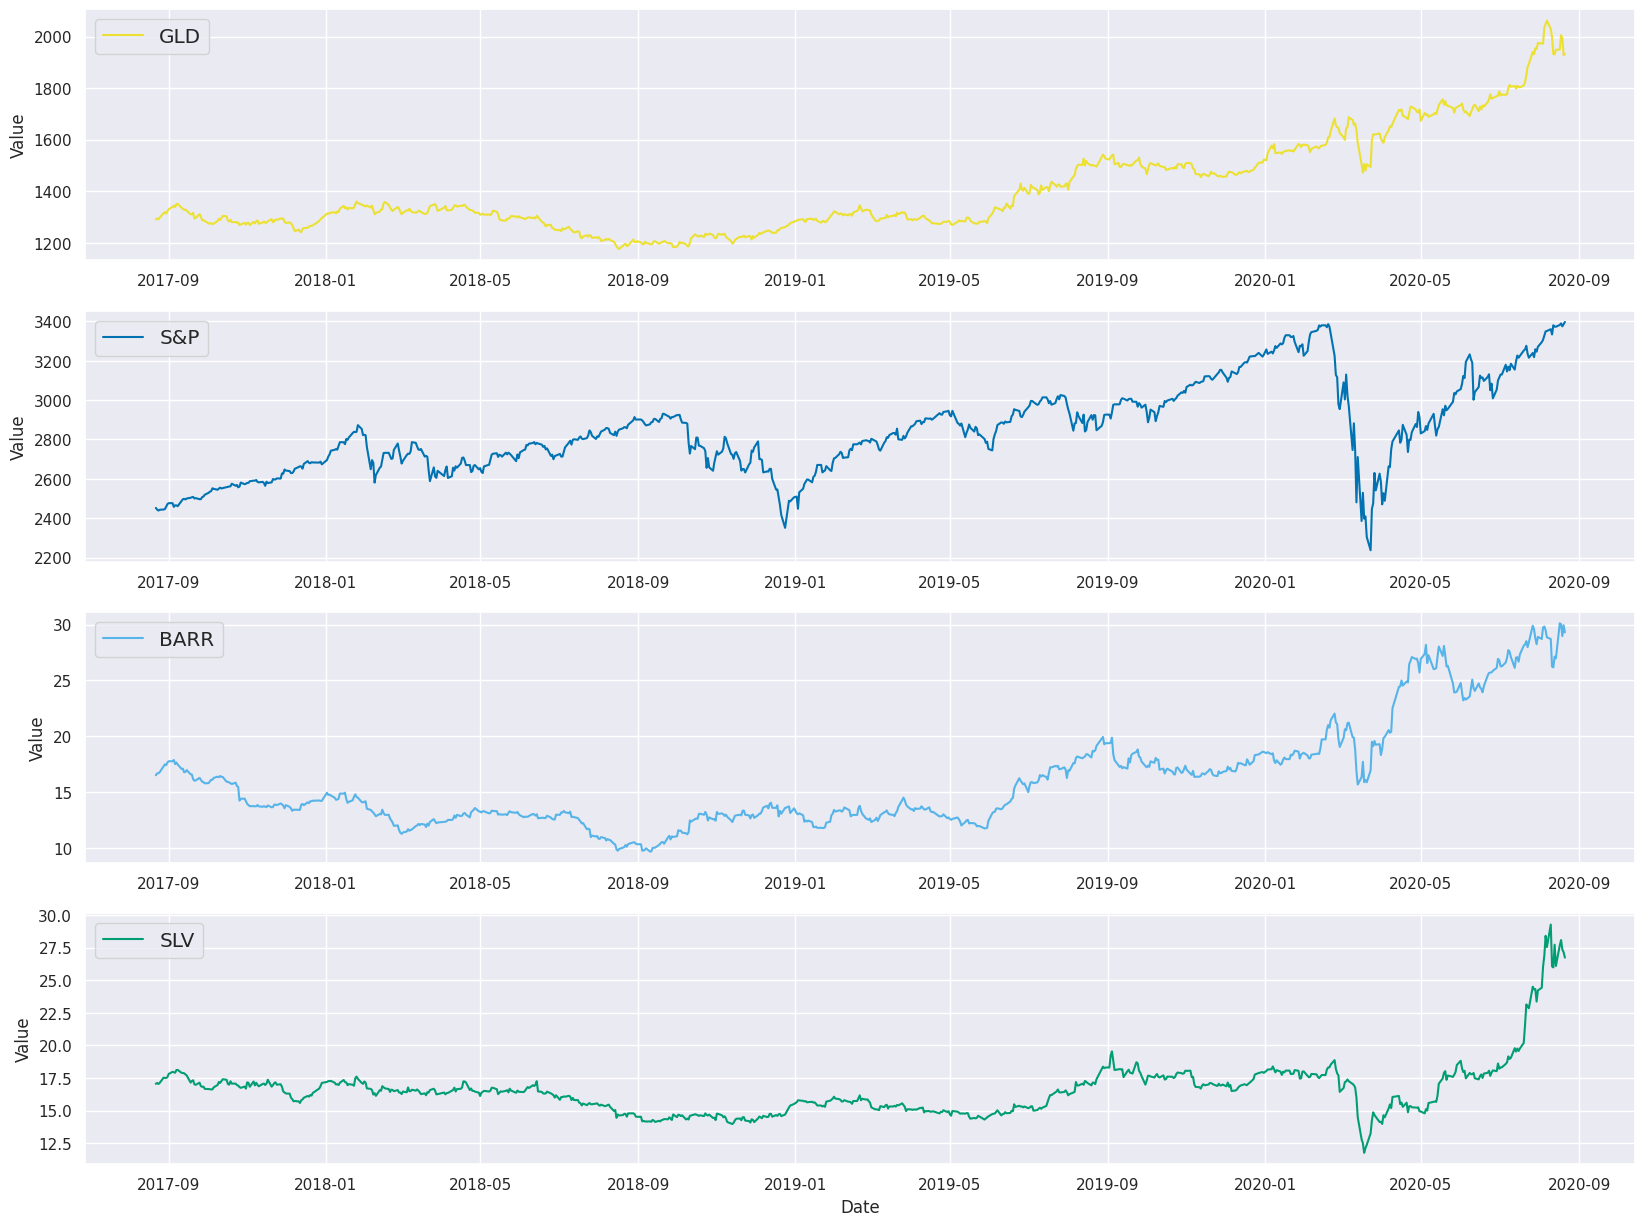

In [54]:
# Plot degli andamenti tmeporali dei costi
plt.figure(figsize=(20,15))
plt.subplot(411)
plt.plot(maindf['GLD'], label='GLD', color='y')
plt.legend(loc='best', fontsize='large')
plt.ylabel('Value')
plt.subplot(412)
plt.plot(maindf['SPX'], label='S&P', color='b')
plt.legend(loc='best', fontsize='large')
plt.ylabel('Value')
plt.subplot(413)
plt.plot(maindf['BARR'], label='BARR', color='c')
plt.legend(loc='best', fontsize='large')
plt.ylabel('Value')
plt.subplot(414)
plt.plot(maindf['SLV'], label='SLV', color='g')
plt.legend(loc='best', fontsize='large')
plt.xlabel('Date')
plt.ylabel('Value')

In [55]:
maindf.shape

(759, 4)

### Forecasting GOLD

 Decisione parametri modello **ARIMA**

In [56]:
# Abbiamo 759 dati. Ne utilizziamo 159 per il test e il resto per il train.
test_dim = 159
df_train, df_test = maindf[0:-test_dim], maindf[-test_dim:]
print(df_train.shape, df_test.shape)

(600, 4) (159, 4)


In [57]:
# Cerchiamo il p-value
adf_result_gold = adfuller(df_train['GLD'])

print('ADF Statistic:', adf_result_gold[0])
print('p-value:', adf_result_gold[1])
print('Valori critici:', adf_result_gold[4])

ADF Statistic: 0.043828959664608744
p-value: 0.9620100700981221
Valori critici: {'1%': -3.441616425652826, '5%': -2.866510292004876, '10%': -2.5694170294713863}


Il p-value risulta essere maggiore di 0.05, dunque la serie è considerata non stazionaria. Bisogna differenziare i dati al fine di rendere la serie stazionaria.

In [58]:
# Differenziamo il train set
df_train_diff = df_train.diff().dropna()

In [59]:
# Cerchiamo il p-value
adf_result_gold = adfuller(df_train_diff['GLD'])

print('ADF Statistic:', adf_result_gold[0])
print('p-value:', adf_result_gold[1])
print('Valori critici:', adf_result_gold[4])

ADF Statistic: -4.231661404275437
p-value: 0.0005821407593177145
Valori critici: {'1%': -3.441616425652826, '5%': -2.866510292004876, '10%': -2.5694170294713863}


Il p-value risulta essere minore di 0.05, dunque la serie ora è stazionaria. Il parametro d del modello arima dunque sarà 1, ossia il numero di differenziazioni necessarie a rendere la serie stazionaria.

Stampiamo i grafici di autocorrelazione e autocorrelazione parziale per cercare i parametri p e q: il primo si ricava contando il numero di valori al di fuori del limite di significatività nel grafico di autocorrelazione, il secondo nel grafico di autocorrelazione parziale.

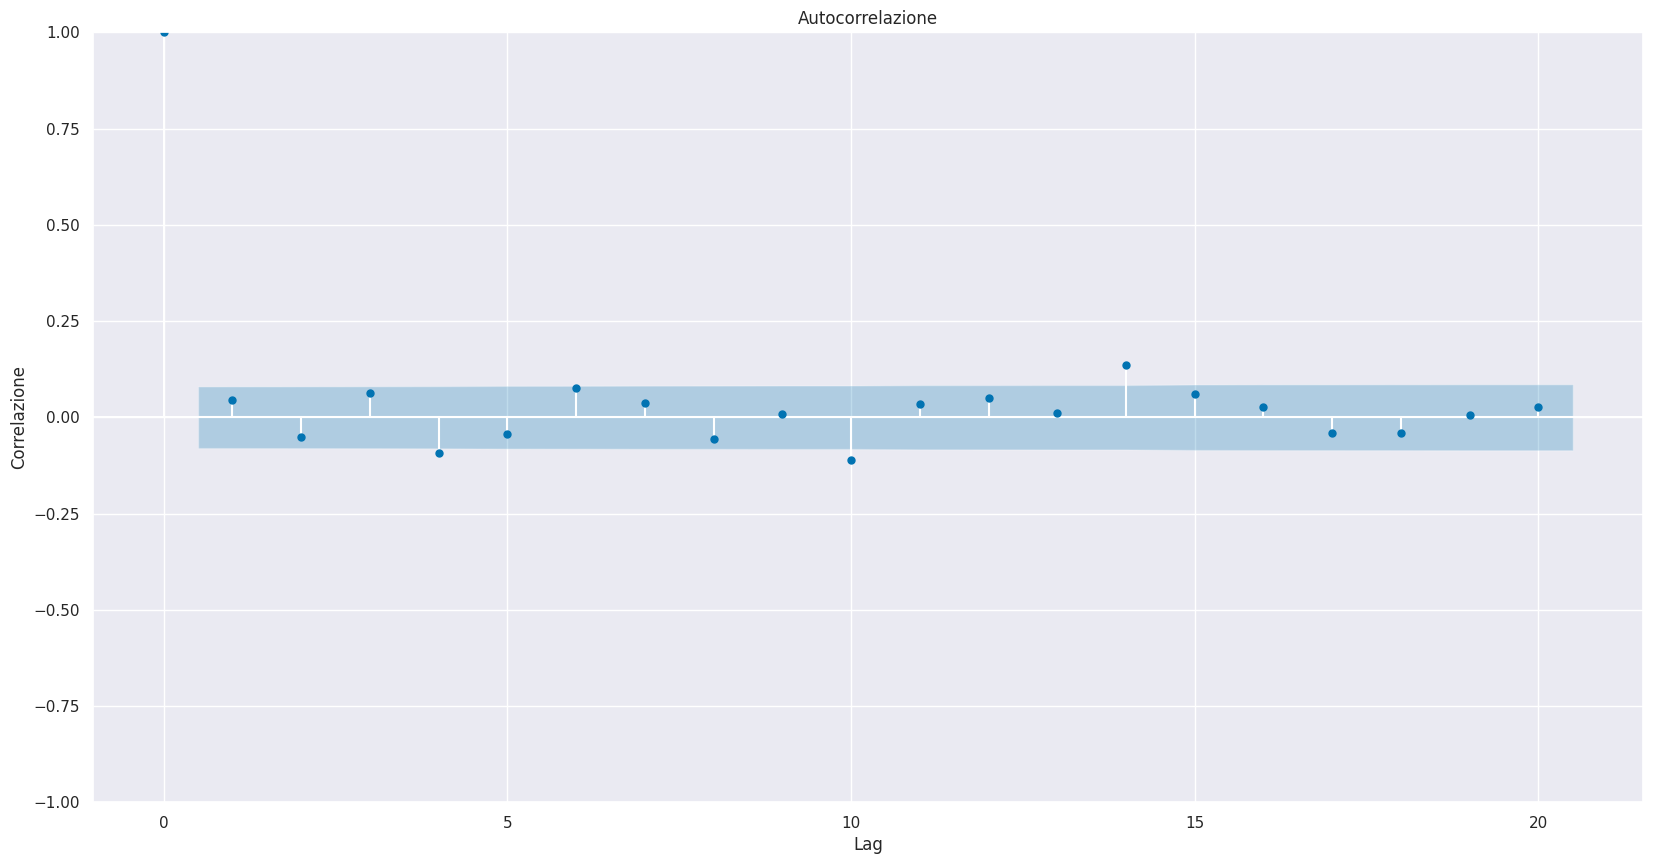

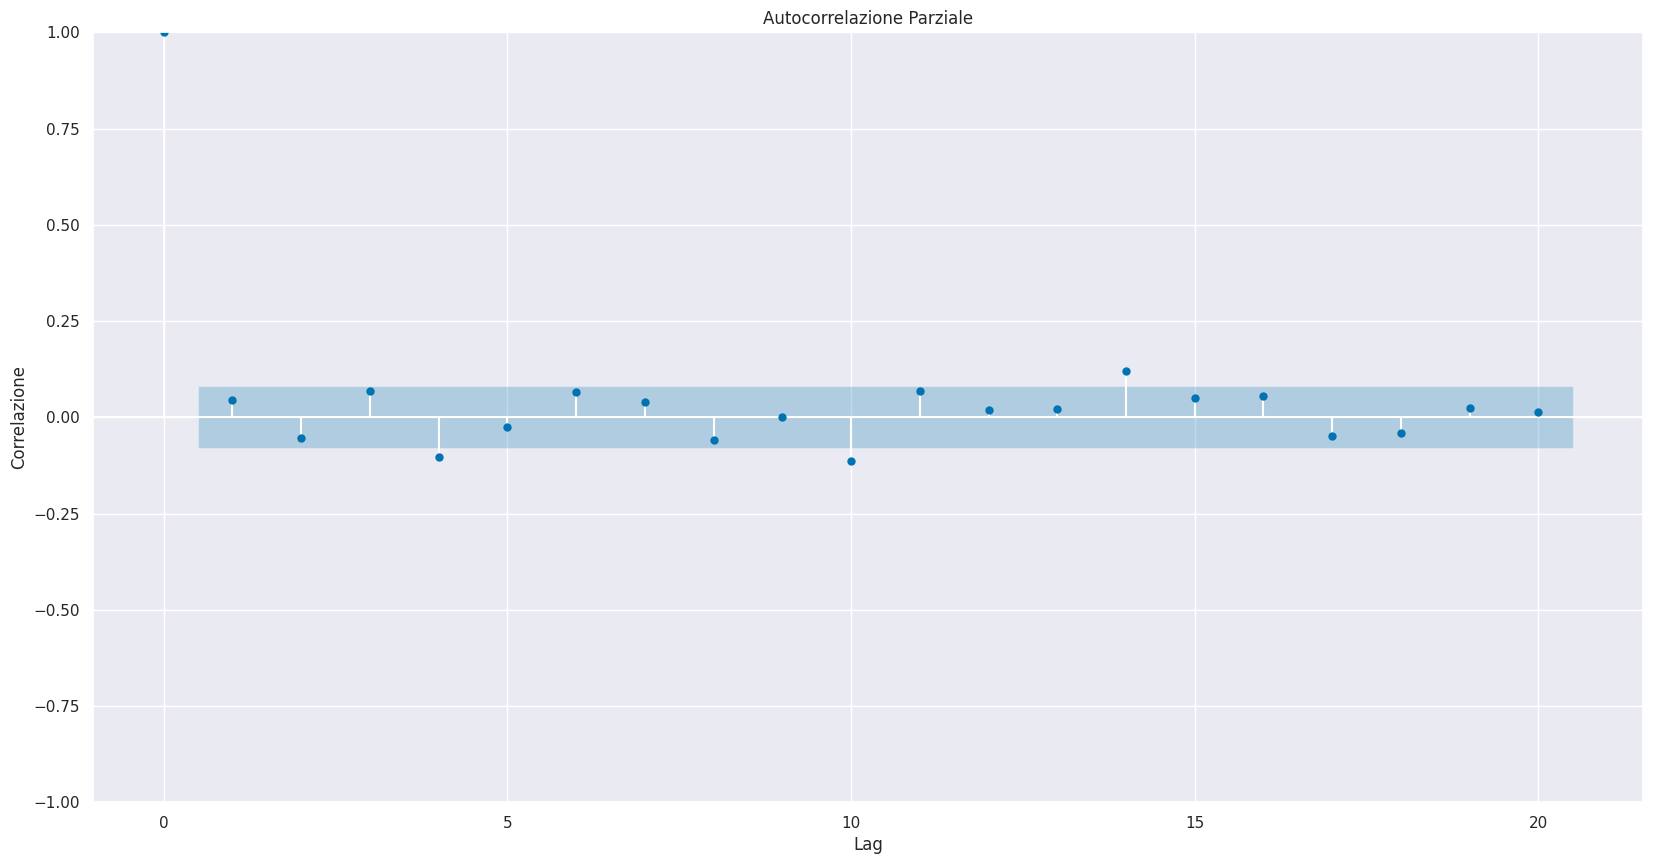

In [60]:
plot_acf(df_train_diff['GLD'], lags=20)
plt.title('Autocorrelazione')
plt.xlabel('Lag')
plt.ylabel('Correlazione')
plt.show()

# Calcola e plotta la PACF del numero di terremoti mensili
plot_pacf(df_train_diff['GLD'], lags=20)
plt.title('Autocorrelazione Parziale')
plt.xlabel('Lag')
plt.ylabel('Correlazione')
plt.show()

Dai grafici poniamo p=3 e q=3.

Nella cella di seguito utilizziamo auto_arima per farci restituire i parametri ottimali e verificare che quelli scelti siano effettivamente i migliori.

In [61]:
model = auto_arima(df_train['GLD'], seasonal=False, suppress_warnings=True)

print("Migliori parametri p, d e q:", model.order)

Migliori parametri p, d e q: (3, 1, 3)


Una volta settati i parametri p, d e q, è possibile addestrare il modello.

In particolare, ciò che viene fatto è addestrare tanti modelli quanti sono i dati di test: ogni volta viene testato un dato di test e al ciclo successivo il modello viene addestrato con il training set più il dato testato precedentemente.

In [63]:
# Creao una lista con i dati di train, al quale vado ad aggiungere passo passo i dati che ho testato.
train = list(df_train['GLD'].values)
predictions = list()
data=list()
period = df_test.index

for index in range(test_dim):
    model_arima = ARIMA(endog = train, order=(3,1,3)).fit()
    prediction = model_arima.forecast()[0]
    predictions.append(prediction)
    real_test_value = df_test['GLD'][index]
    train.append(real_test_value)
    data.append([period[index], real_test_value, prediction])


In [64]:
RMSE = (mean_squared_error(df_test['GLD'], predictions))**0.5
arima_results = pd.DataFrame(data,columns=['Period','Actual Price', 'Predicted Price'])
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 23.179


In [65]:
arima_results.head()

,Period,Actual Price,Predicted Price
0,2020-01-07,1566.50,1575.313985
1,2020-01-08,1582.85,1568.100085
2,2020-01-09,1547.85,1584.954667
3,2020-01-10,1548.80,1543.571743
4,2020-01-13,1550.35,1550.800404


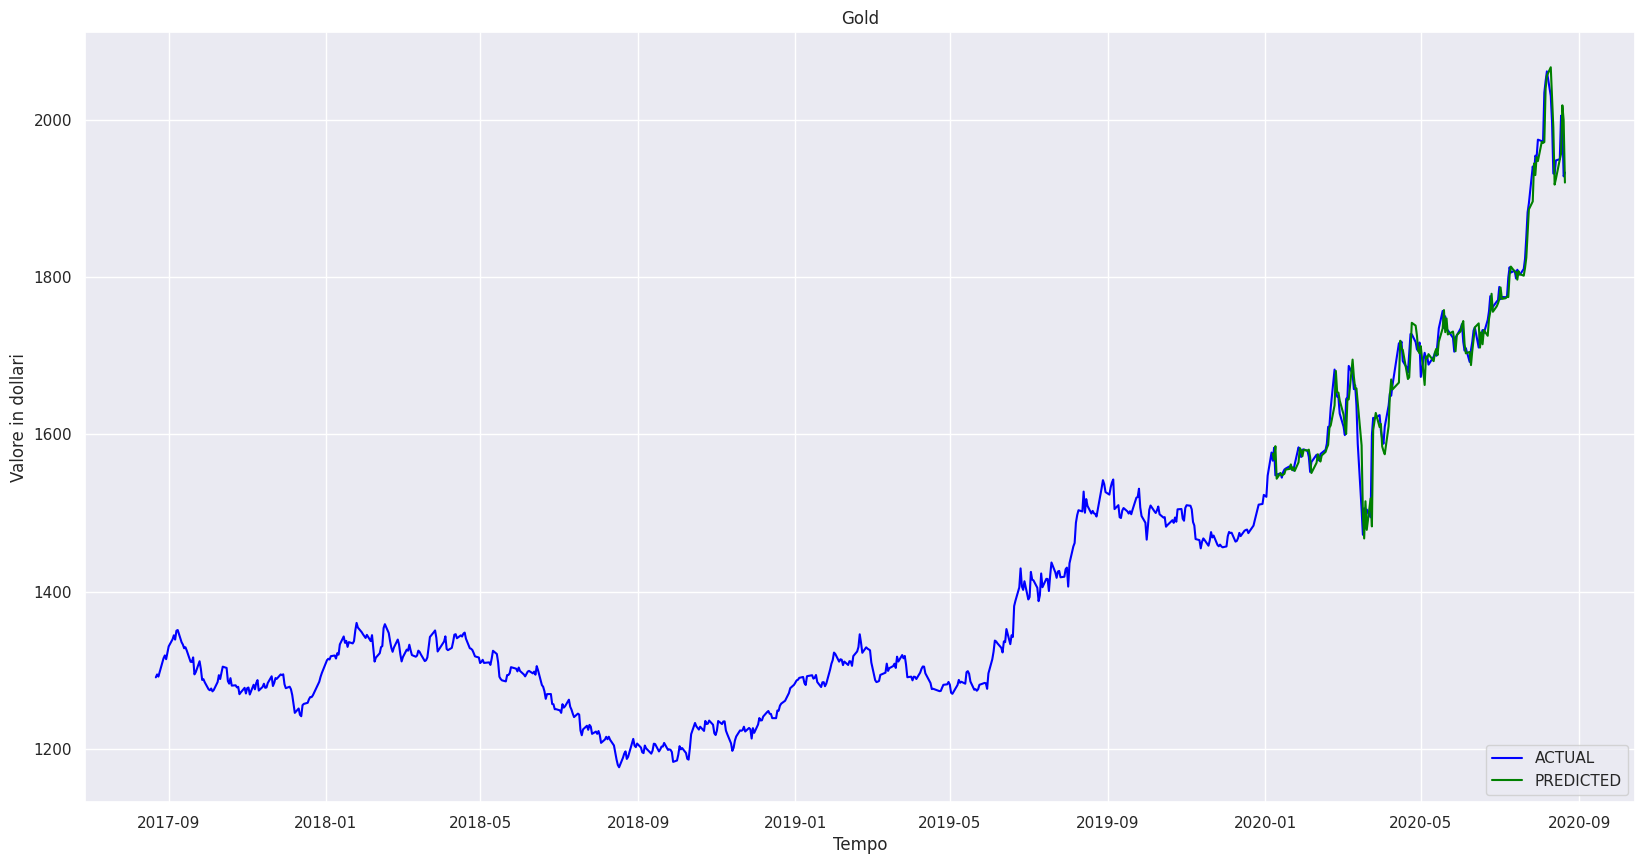

In [66]:
# plot
plt.title('Gold')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(maindf.index, maindf['GLD'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

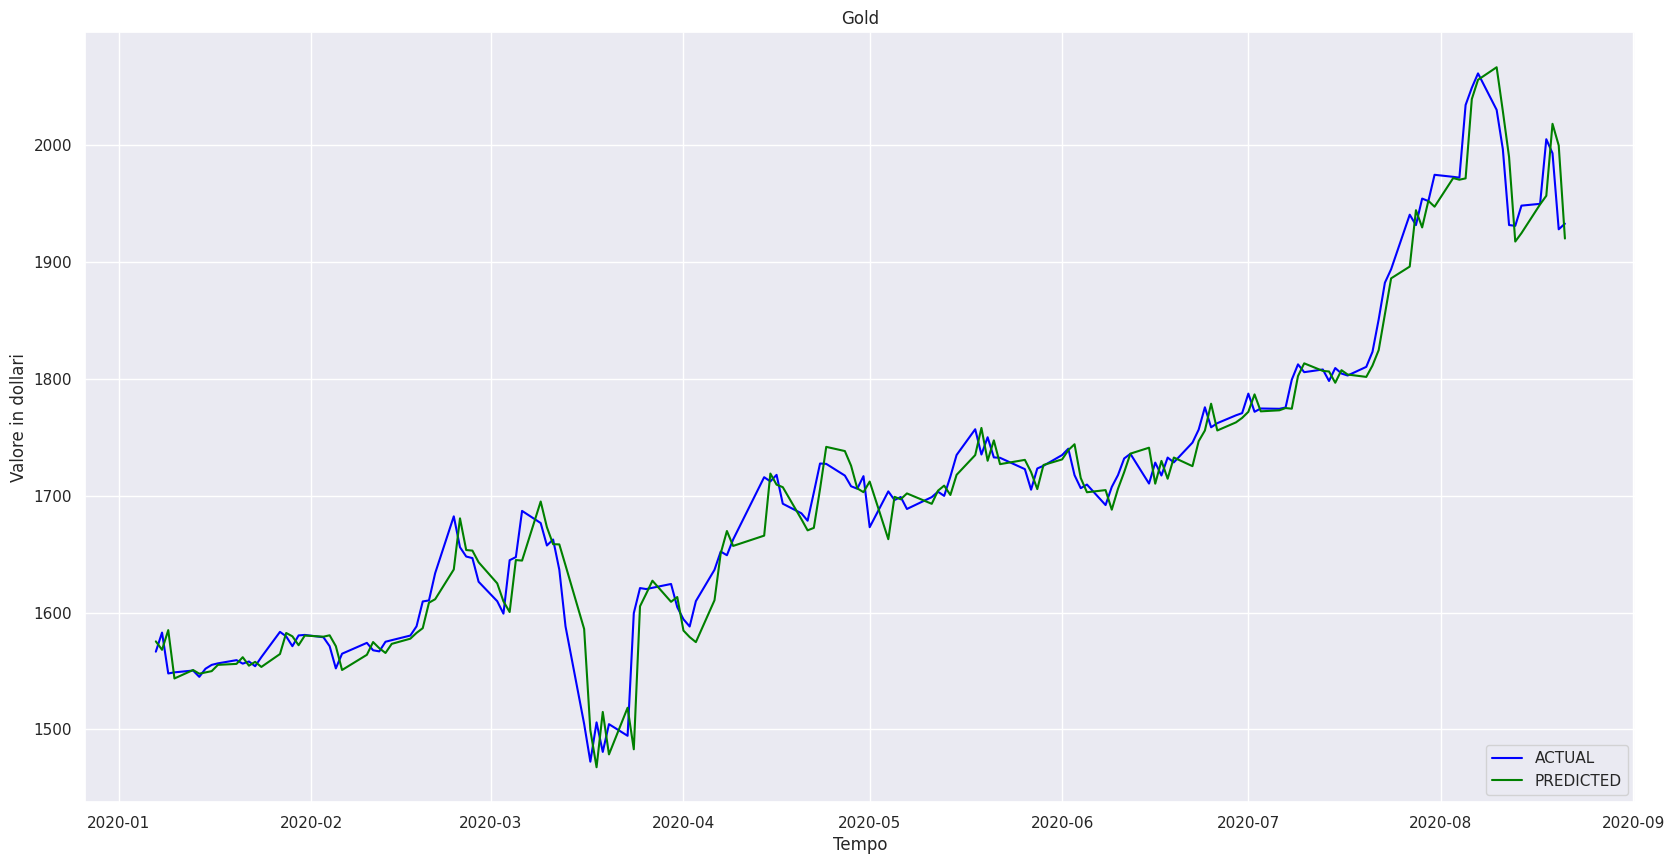

In [67]:
# plot
plt.title('Gold')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(df_test.index, df_test['GLD'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

### Forecasting S&P 500

In [68]:
model = auto_arima(df_train['SPX'], seasonal=False, suppress_warnings=True)

print("Migliori parametri p, d e q:", model.order)

Migliori parametri p, d e q: (2, 1, 1)


In [69]:
# Creao una lista con i dati di train, al quale vado ad aggiungere passo passo i dati che ho testato.
train = list(df_train['SPX'].values)
predictions = list()
data=list()
period = df_test.index

for index in range(test_dim):
    model_arima = ARIMA(endog = train, order=(2,1,1)).fit()
    prediction = model_arima.forecast()[0]
    predictions.append(prediction)
    real_test_value = df_test['SPX'][index]
    train.append(real_test_value)
    data.append([period[index], real_test_value, prediction])


In [70]:
RMSE = (mean_squared_error(df_test['SPX'], predictions))**0.5
arima_results = pd.DataFrame(data,columns=['Period','Actual Price', 'Predicted Price'])
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 68.534


In [71]:
arima_results.head()

,Period,Actual Price,Predicted Price
0,2020-01-07,3237.18,3249.021479
1,2020-01-08,3253.05,3233.697850
2,2020-01-09,3274.70,3256.906485
3,2020-01-10,3265.35,3269.622015
4,2020-01-13,3288.13,3267.813029


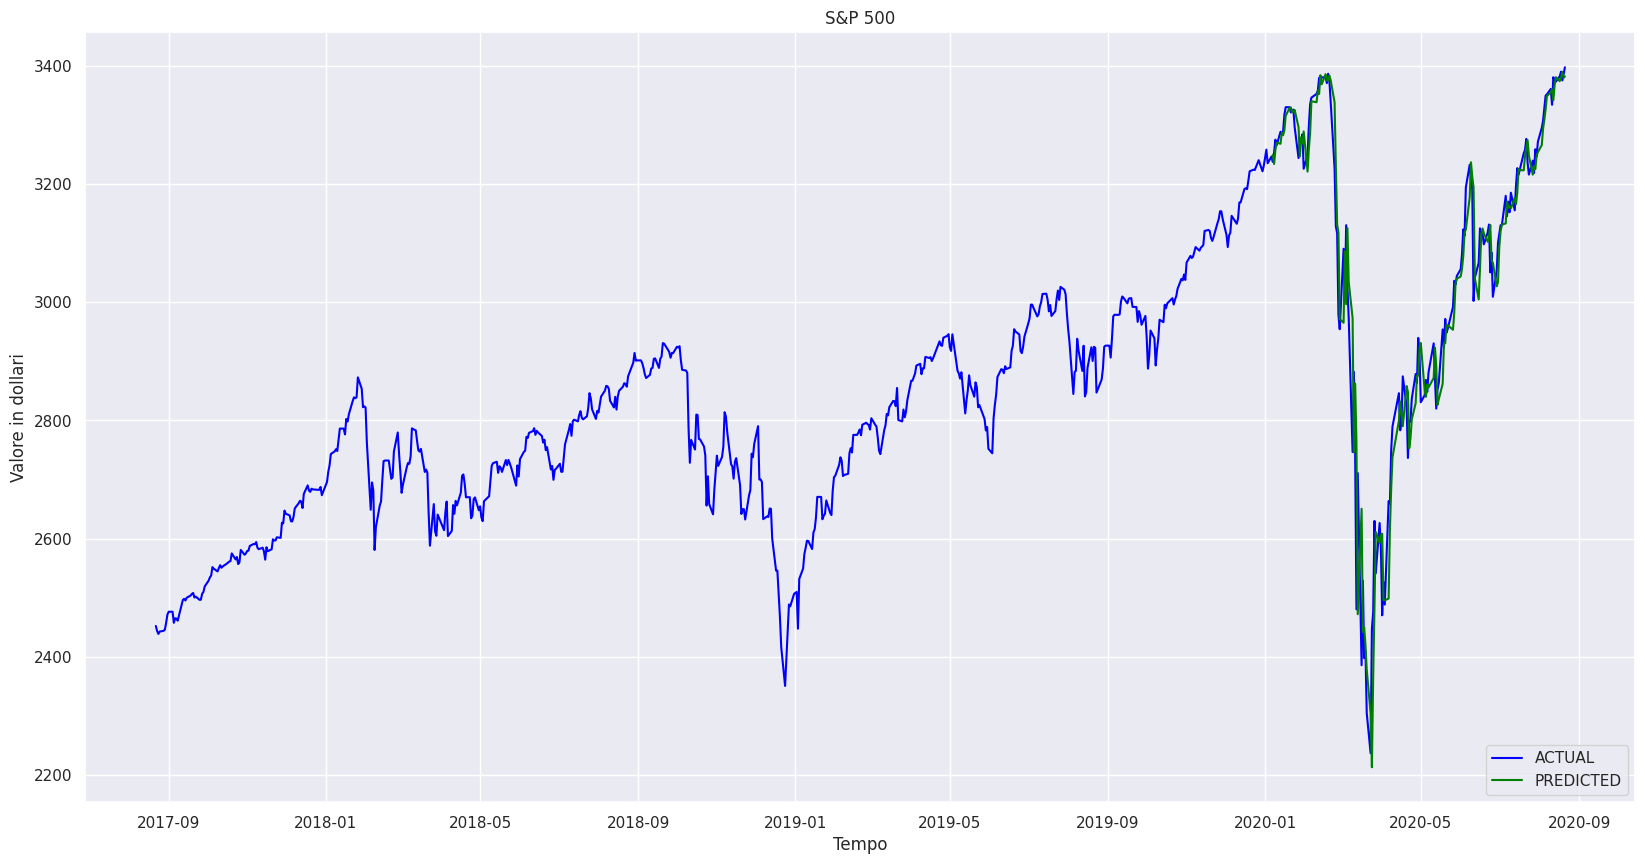

In [72]:
# plot
plt.title('S&P 500')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(maindf.index, maindf['SPX'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()

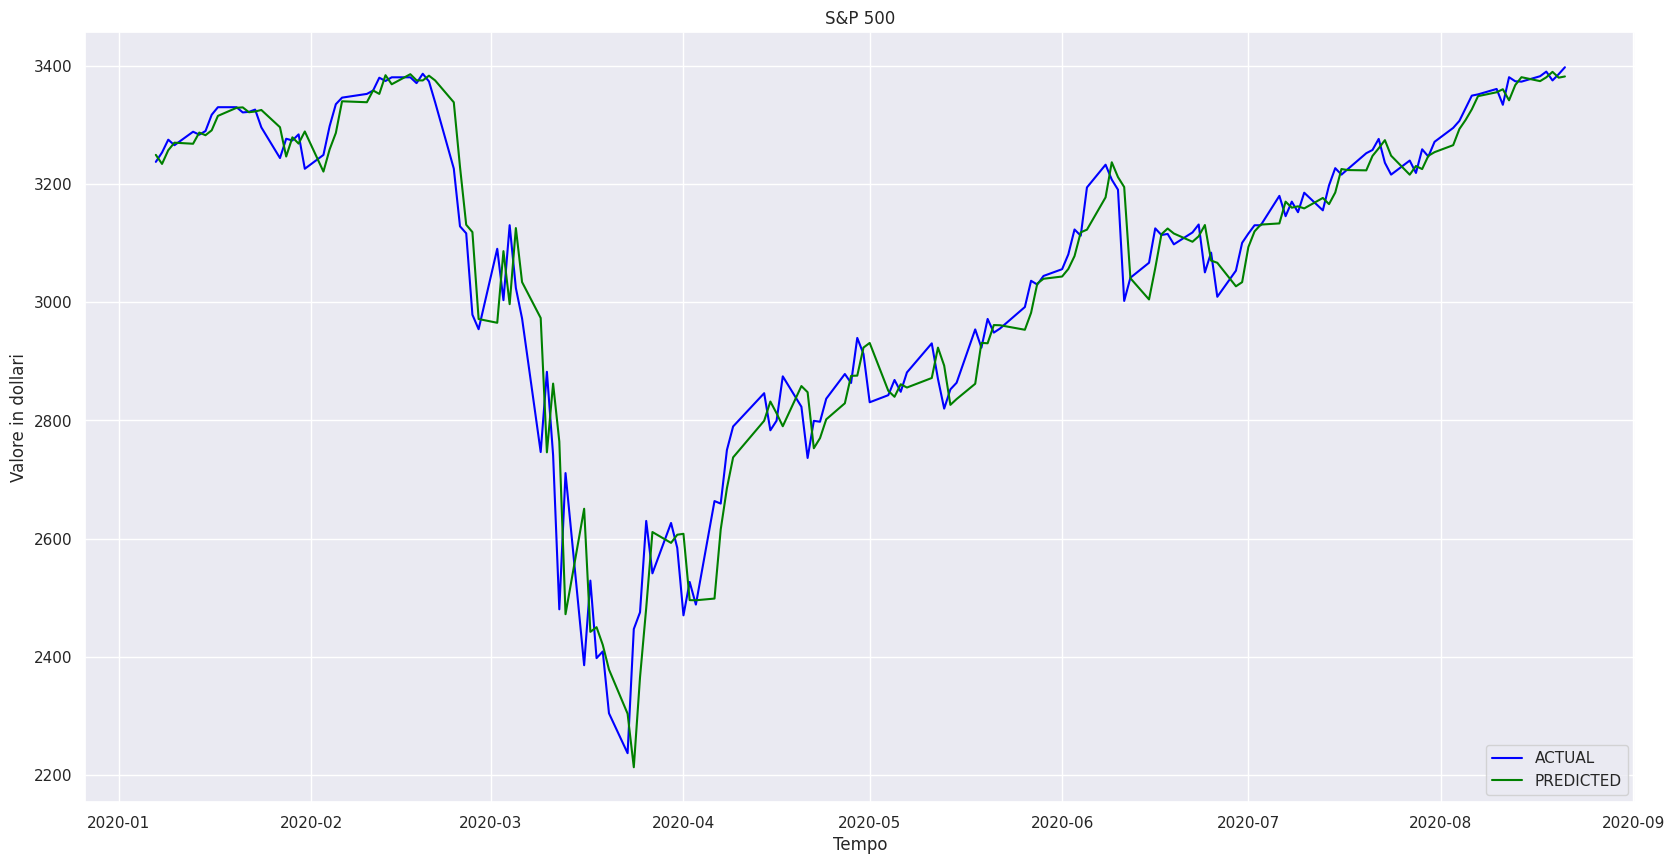

In [73]:
# plot
plt.title('S&P 500')
plt.rcParams['figure.figsize'] = (20,10)
plt.xlabel('Tempo')
plt.ylabel('Valore in dollari')
plt.plot(df_test.index, df_test['SPX'], color='Blue', label='ACTUAL', marker='')
plt.plot(df_test.index, predictions, color='green', label='PREDICTED', marker='')
plt.legend(loc='lower right')
plt.show()